# DuckDB + Spatial Extension Scalability Test
This notebook benchmarks the scalability of DuckDB Spatial using real city data from OpenStreetMap.
We test with increasing urban complexity: Pinerolo, Milano, Roma and Tokyo.

In [3]:
# Import libraries
import os
import time
import duckdb
import osmnx as ox
import pandas as pd
from shapely import wkt
import matplotlib.pyplot as plt
import seaborn as sns

## Starting the benchmark test

The test needs some nominal and type adjustments before its start.

We use overpass to get direct access to every OpenStreetMap data.

In [4]:
# Prepare DuckDB with spatial extension
con = duckdb.connect('data/benchmark/benchmark.duckdb')
con.execute("INSTALL spatial;")
con.execute("LOAD spatial;")

# Define cities to benchmark
cities = ["Pinerolo, Piemonte, Italy", "Milano, Lombardia, Italy", "Roma, Lazio, Italy", "Tokyo, Japan"]
results = []

# Normalize a city name to use as table suffix
def normalize_city_name(city):
    return city.lower().replace(",", "").replace(" ", "_")

# Loop over each city to download, process, and insert data
for city in cities:
    print(f"\nProcessing {city}...")

    ox.settings.overpass_endpoint = "https://overpass.kumi.systems/api"
    table_suffix = normalize_city_name(city)

    try:
        # Get city polygon
        gdf = ox.geocode_to_gdf(city)
        polygon = gdf.loc[0, 'geometry']

        # Download street network
        G = ox.graph_from_polygon(polygon, network_type='drive')

        # Convert graph to GeoDataFrames
        nodes, edges = ox.graph_to_gdfs(G)

        # Convert geometries to WKT
        nodes['geometry_wkt'] = nodes['geometry'].apply(lambda geom: geom.wkt)
        edges['geometry_wkt'] = edges['geometry'].apply(lambda geom: geom.wkt)

        # Clean and register dataframes
        nodes_clean = nodes.drop(columns=['geometry']).copy()
        edges_clean = edges.drop(columns=['geometry']).copy()

        # Convert problematic columns (like arrays or mixed types) to strings
        for df in [nodes_clean, edges_clean]:
            for col in df.columns:
                if df[col].apply(lambda x: isinstance(x, list)).any():
                    df[col] = df[col].astype(str)

        con.register('nodes_df', nodes_clean)
        con.register('edges_df', edges_clean)

        # Create dedicated tables per city
        con.execute(f"""
            CREATE TABLE IF NOT EXISTS nodes_{table_suffix} AS
            SELECT * FROM nodes_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO nodes_{table_suffix}
            SELECT * FROM nodes_df;
        """)

        con.execute(f"""
            CREATE TABLE IF NOT EXISTS edges_{table_suffix} AS
            SELECT * FROM edges_df WHERE FALSE;
        """)
        con.execute(f"""
            INSERT INTO edges_{table_suffix}
            SELECT * FROM edges_df;
        """)

        # Time spatial query on city's edges table
        start = time.time()
        con.execute(f"""
            SELECT COUNT(*) FROM edges_{table_suffix}
            WHERE ST_Length(ST_GeomFromText(geometry_wkt)) > 100
        """)
        query_time = time.time() - start

        # Measure DB file size
        db_size = os.path.getsize("data/benchmark/benchmark.duckdb") / (1024 ** 2)  # MB

        # Save result
        results.append({
            'City': city,
            'Nodes': len(nodes),
            'Edges': len(edges),
            'Query Time (s)': round(query_time, 3),
            'DB Size (MB)': round(db_size, 2)
        })

    except Exception as e:
        print(f"Error processing {city}: {e}")

# Show results
summary = pd.DataFrame(results)
print(summary)
summary.to_csv("data/benchmark/duckdb_scalability_summary.csv", index=False)


Processing Pinerolo, Piemonte, Italy...

Processing Milano, Lombardia, Italy...

Processing Roma, Lazio, Italy...

Processing Tokyo, Japan...


C:\Users\Ale\Documents\.venv\Lib\site-packages\osmnx\_overpass.py:267: UserWarning: This area is 651 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


                        City   Nodes   Edges  Query Time (s)  DB Size (MB)
0  Pinerolo, Piemonte, Italy    1155    2478           0.012          0.01
1   Milano, Lombardia, Italy   12898   25419           0.149          0.01
2         Roma, Lazio, Italy   43557   90240           0.500         26.51
3               Tokyo, Japan  237509  633282           0.566         84.76


## Looking at the results

We can look at the results of the benchmark test via some graphs of different types.

                        City   Nodes   Edges  Query Time (s)  DB Size (MB)
0  Pinerolo, Piemonte, Italy    1155    2478           0.012          0.01
1   Milano, Lombardia, Italy   12898   25419           0.149          0.01
2         Roma, Lazio, Italy   43557   90240           0.500         26.51
3               Tokyo, Japan  237509  633282           0.566         84.76


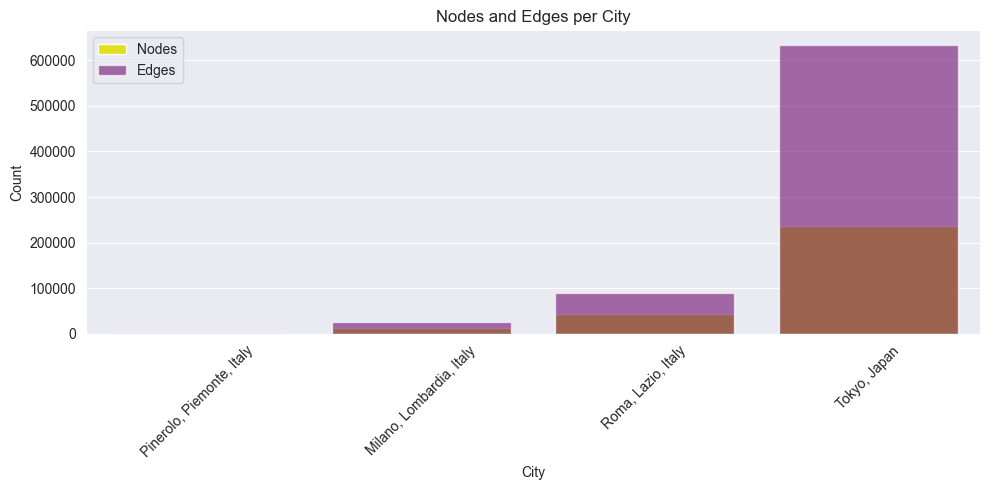

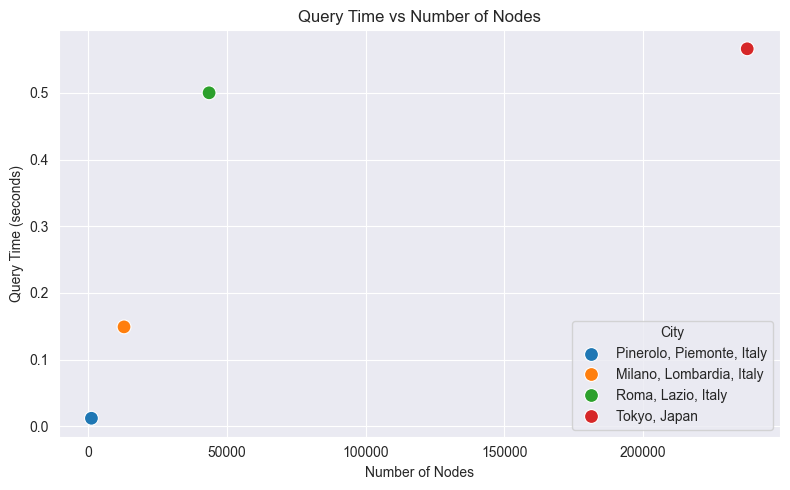

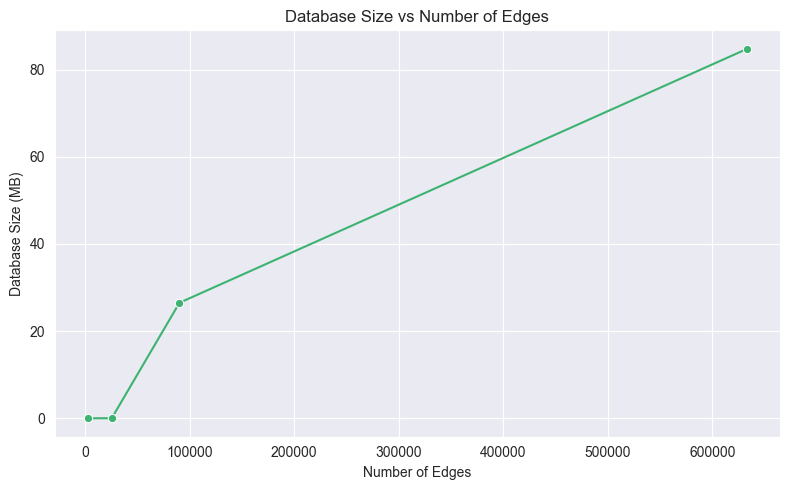

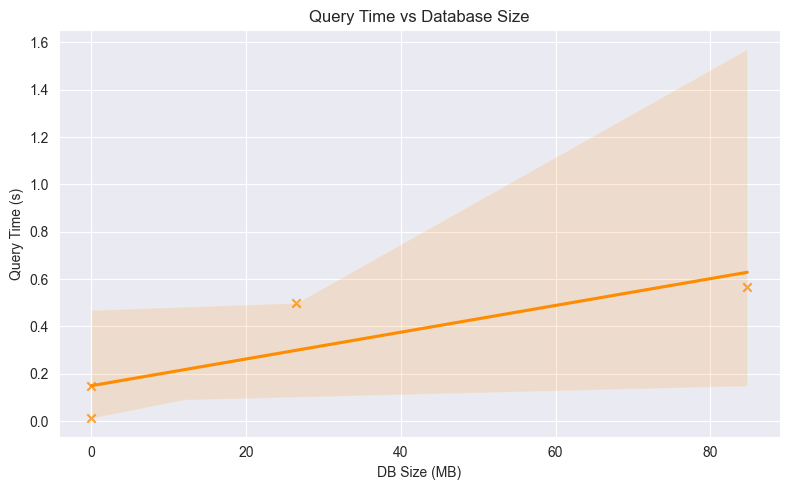

Correlation Matrix:
                   Nodes     Edges  Query Time (s)  DB Size (MB)
Nodes           1.000000  0.999282        0.758862      0.986066
Edges           0.999282  1.000000        0.733674      0.980097
Query Time (s)  0.758862  0.733674        1.000000      0.841598
DB Size (MB)    0.986066  0.980097        0.841598      1.000000


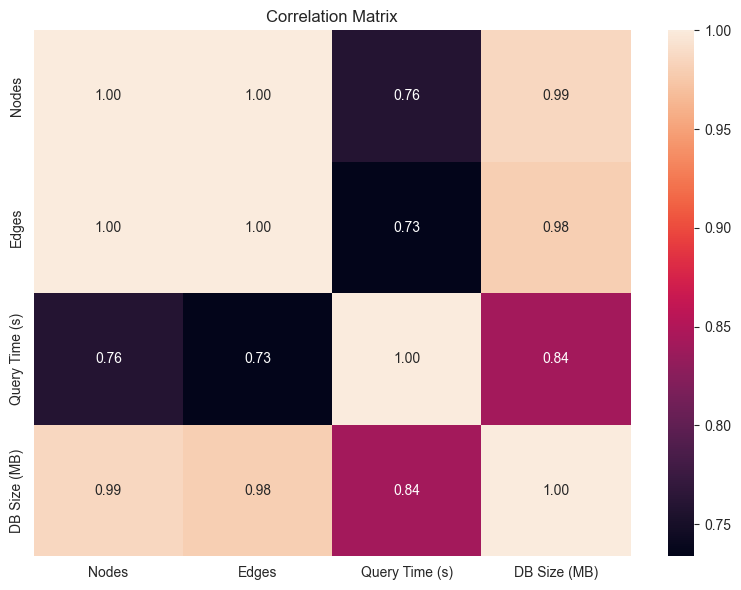

In [5]:
# Load results from CSV file
df = pd.read_csv("data/benchmark/duckdb_scalability_summary.csv")

# Display the content
print(df)

# Barplot: Nodes and Edges per City
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="City", y="Nodes", color='yellow', label="Nodes")
sns.barplot(data=df, x="City", y="Edges", color='purple', label="Edges", alpha=0.6)
plt.title("Nodes and Edges per City")
plt.ylabel("Count")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Scatterplot: Query Time vs Nodes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="Nodes", y="Query Time (s)", hue="City", s=100)
plt.title("Query Time vs Number of Nodes")
plt.xlabel("Number of Nodes")
plt.ylabel("Query Time (seconds)")
plt.tight_layout()
plt.show()

# Lineplot: DB Size vs Edges
plt.figure(figsize=(8, 5))
sns.lineplot(data=df, x="Edges", y="DB Size (MB)", marker='o', color='mediumseagreen')
plt.title("Database Size vs Number of Edges")
plt.xlabel("Number of Edges")
plt.ylabel("Database Size (MB)")
plt.tight_layout()
plt.show()

# Regression plot: Query Time vs DB Size
plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="DB Size (MB)", y="Query Time (s)", marker='x', color='darkorange')
plt.title("Query Time vs Database Size")
plt.tight_layout()
plt.show()

# Select numeric columns only
numeric_df = df[["Nodes", "Edges", "Query Time (s)", "DB Size (MB)"]]

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Print the matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="rocket", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()